Привет, меня зовут Артем Носенко и я буду проверять твой проект.
<br>Небольшая вступительная часть и начнем работу)
<br> Если не против, то предлагаю общаться на «ты». Если это не удобно - дай знать, и мы перейдем на "вы". Моя основная цель — не указать на совершенные ошибки, а поделиться своим опытом и помочь сделать твой проект лучше. Для этого я буду использовать разный стиль оформления комментариев.
<div class="alert alert-block alert-success">
✔️ Все хорошо.
</div>

<div class="alert alert-warning">
⚠️ Критических замечаний нет, но есть возможность сделать твою работу лучше.
</div>

<div class="alert alert-block alert-danger">
❌ Если требуются исправления. Работа не может быть принята с красными комментариями.
</div>


Давай работать над проектом в диалоге: если ты что-то меняешь в проекте по моим рекомендациям — пиши об этом.
Будет очень хорошо, если ты будешь помечать свои действия следующим образом:
<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> ...
</div>
Пожалуйста, не перемещай, не изменяй и не удаляй мои комментарии. Всё это поможет выполнить повторную проверку твоего проекта оперативнее».


# Инициализация

Загружаем библиотеки необходимые для выполнения кода ноутбука.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# === ЭТАП 1 ===

# Загрузка первичных данных

Загружаем первичные данные из файлов:
- tracks.parquet
- catalog_names.parquet
- interactions.parquet

In [2]:
tracks = pd.read_parquet('data/tracks.parquet')
interactions = pd.read_parquet('data/interactions.parquet')
catalog = pd.read_parquet('data/catalog_names.parquet')


<b>Комментарий от ревьюера v1</b>
<div class="alert alert-block alert-success">
✔️ Основные импорты сделаны, отлично!
</div>

# Обзор данных

Проверяем данные, есть ли с ними явные проблемы.

In [3]:
tracks.head()

track_id                                             albums artists  \
0        26                                       [3, 2490753]    [16]   
1        38                                       [3, 2490753]    [16]   
2       135                                 [12, 214, 2490809]    [84]   
3       136                                 [12, 214, 2490809]    [84]   
4       138  [12, 214, 322, 72275, 72292, 91199, 213505, 24...    [84]   

     genres                                 name  count  
0  [11, 21]                     Complimentary Me      5  
1  [11, 21]                          Momma's Boy      8  
2      [11]                              Atticus     16  
3      [11]                             24 Hours      7  
4      [11]  Don't Upset The Rhythm (Go Baby Go)     17

In [4]:
tracks['empty_genre'] = tracks['genres'].apply(lambda alb: len(alb) == 0)
tracks['empty_album'] = tracks['albums'].apply(lambda alb: len(alb) == 0)
tracks['empty_artist'] = tracks['artists'].apply(lambda alb: len(alb) == 0)

In [5]:
tracks = tracks.loc[~tracks['empty_artist']]
tracks = tracks.loc[~tracks['empty_album']]
tracks = tracks.loc[~tracks['empty_genre']]
len(tracks)

932664

In [6]:
catalog.loc[(catalog.type == 'track') & (catalog.id == 38012 )]

id   type        name
819116  38012  track  The Riddle

In [7]:
genre_list = catalog.loc[catalog.type=='genre', 'id'].values
print(len(genre_list))
album_list = catalog.loc[catalog.type=='album', 'id'].values
print(len(album_list))
artist_list = catalog.loc[catalog.type=='artist', 'id'].values
print(len(artist_list))

166
658724
153581


Все данные на месте. Проблема в том что три столбца - ndarray

In [8]:
tracks['unknown_genre'] = tracks['genres'].apply(lambda alb: sum([1 if a in genre_list else 0 for a in alb]) / len(alb))
tracks.query('unknown_genre < 1')

Empty DataFrame
Columns: [track_id, albums, artists, genres, name, count, empty_genre, empty_album, empty_artist, unknown_genre]
Index: []

In [9]:
tracks['unknown_artist'] = tracks['artists'].apply(lambda alb: sum([1 if a in artist_list else 0 for a in alb]) / len(alb))
tracks.query('unknown_artist < 1')

Empty DataFrame
Columns: [track_id, albums, artists, genres, name, count, empty_genre, empty_album, empty_artist, unknown_genre, unknown_artist]
Index: []

In [10]:
#tracks['unknown_album'] = tracks['albums'].apply(lambda alb: sum([1 if a in album_list else 0 for a in alb]) / len(alb))
#tracks.query('unknown_album < 1')

In [11]:
tracks = tracks.loc[tracks['unknown_genre'] == 1]

In [12]:
track_list = tracks.track_id.unique()

In [13]:
interactions.info()
interactions.nunique()

<class 'pandas.core.frame.DataFrame'>
Index: 214714415 entries, 0 to 291
Data columns (total 4 columns):
 #   Column      Dtype         
---  ------      -----         
 0   user_id     int32         
 1   track_id    int32         
 2   track_seq   int16         
 3   started_at  datetime64[ns]
dtypes: datetime64[ns](1), int16(1), int32(2)
memory usage: 5.2 GB


user_id       1368700
track_id       932664
track_seq       16636
started_at        365
dtype: int64

In [14]:
interactions = interactions.loc[interactions['track_id'].isin(track_list)]


In [15]:
interactions.info()
interactions.nunique()

<class 'pandas.core.frame.DataFrame'>
Index: 214714415 entries, 0 to 291
Data columns (total 4 columns):
 #   Column      Dtype         
---  ------      -----         
 0   user_id     int32         
 1   track_id    int32         
 2   track_seq   int16         
 3   started_at  datetime64[ns]
dtypes: datetime64[ns](1), int16(1), int32(2)
memory usage: 5.2 GB


user_id       1368700
track_id       932664
track_seq       16636
started_at        365
dtype: int64

In [16]:
def flat_index(df_stats): 
    df_stats.columns = df_stats.columns.get_level_values(0) + '_' +  df_stats.columns.get_level_values(1) 
    df_stats.columns.to_flat_index() 
    df_stats.columns = df_stats.columns.to_flat_index() 
    df_stats.reset_index(inplace=True) 
    return df_stats

In [17]:
numeric_cols = interactions.select_dtypes(include=['int16','int32']).columns.tolist()
numeric_cols

['user_id', 'track_id', 'track_seq']

In [18]:
users_grouped = interactions[numeric_cols].groupby('user_id').agg(['count', 'sum', 'max'])
users_grouped = flat_index(users_grouped)

In [19]:
users_grouped

user_id  track_id_count  track_id_sum  track_id_max  track_seq_count  \
0              0              26     222329191      20497621               26   
1              1              36    1433967998      83436771               36   
2              2              13     382479927      71650200               13   
3              3              33    1437092275      78194999               33   
4              4             245    8570567142      98766295              245   
...          ...             ...           ...           ...              ...   
1368695  1374578              11     360121964      35785893               11   
1368696  1374579              23     178064881      41899516               23   
1368697  1374580             274   10513244081      96618101              274   
1368698  1374581             503   21329665736      99242432              503   
1368699  1374582             290   17626701721     100736375              290   

         track_seq_sum  track_seq_max  
0                  351             26  
1                  666             36  
2                  103             14  
3                  561             33  
4                31738            256  
...                ...            ...  
1368695             66             11  
1368696            289             24  
1368697          37911            277  
1368698         126756            503  
1368699          42717            292  

[1368700 rows x 7 columns]

In [20]:
tracks_grouped = interactions[numeric_cols].groupby('track_id').agg(['count','sum','max'])
tracks_grouped = flat_index(tracks_grouped)
tracks_grouped

track_id  user_id_count  user_id_sum  user_id_max  track_seq_count  \
0              26              5      3187389      1008720                5   
1              38              8      6510921      1304168                8   
2             135             16     11203352      1324586               16   
3             136              7      5253974      1203184                7   
4             138             17     15656791      1324586               17   
...           ...            ...          ...          ...              ...   
932659  101478482              6      2809606      1055764                6   
932660  101490148             72     44514110      1322150               72   
932661  101493057              9      6855759      1294431                9   
932662  101495927             20     15485868      1320566               20   
932663  101521819             34     24517206      1350411               34   

        track_seq_sum  track_seq_max  
0                   5              1  
1                   9              2  
2                  16              1  
3                  10              2  
4                  25              3  
...               ...            ...  
932659           5549           4910  
932660          38987           4911  
932661          11969           4912  
932662           9718           1146  
932663          19324           2768  

[932664 rows x 7 columns]

In [21]:
tracks_grouped

track_id  user_id_count  user_id_sum  user_id_max  track_seq_count  \
0              26              5      3187389      1008720                5   
1              38              8      6510921      1304168                8   
2             135             16     11203352      1324586               16   
3             136              7      5253974      1203184                7   
4             138             17     15656791      1324586               17   
...           ...            ...          ...          ...              ...   
932659  101478482              6      2809606      1055764                6   
932660  101490148             72     44514110      1322150               72   
932661  101493057              9      6855759      1294431                9   
932662  101495927             20     15485868      1320566               20   
932663  101521819             34     24517206      1350411               34   

        track_seq_sum  track_seq_max  
0                   5              1  
1                   9              2  
2                  16              1  
3                  10              2  
4                  25              3  
...               ...            ...  
932659           5549           4910  
932660          38987           4911  
932661          11969           4912  
932662           9718           1146  
932663          19324           2768  

[932664 rows x 7 columns]

In [22]:
small_users = users_grouped.query('track_id_count <= 3')['user_id'] # пользователи, прослушавшие менее 3 треков
interactions = interactions.loc[~interactions['user_id'].isin(small_users)]


In [23]:
catalog_tracks = catalog.loc[catalog.type=='track'][['id', 'name']]
catalog_tracks.to_parquet('data/catalog_tracks.parquet')
catalog_tracks


id                                 name
812471          26                     Complimentary Me
812472          38                          Momma's Boy
812473         135                              Atticus
812474         136                             24 Hours
812475         138  Don't Upset The Rhythm (Go Baby Go)
...            ...                                  ...
1812466  101478482                              На лицо
1812467  101490148                      Без капли мысли
1812468  101493057                             SKITTLES
1812469  101495927                               Москва
1812470  101521819                               Вокзал

[1000000 rows x 2 columns]

In [24]:
catalog_genres = catalog.loc[catalog.type=='genre'][['id', 'name']]
catalog_genres.to_parquet('data/catalog_genres.parquet')
catalog_genres

id          name
812305     0           all
812306     1       eastern
812307     2       rusrock
812308     3        rusrap
812309     4      postrock
...      ...           ...
812466  1182        balkan
812467  1197  experimental
812468  1370       europop
812469  1484    meditation
812470  1542       asiapop

[166 rows x 2 columns]

In [25]:
catalog_albums = catalog.loc[catalog.type=='album'][['id', 'name']]
catalog_albums.to_parquet('data/catalog_albums.parquet')
catalog_albums

id                                     name
0              3                          Taller Children
1             12                        Wild Young Hearts
2             13                            Lonesome Crow
3             17                            Graffiti Soul
4             26                           Blues Six Pack
...          ...                                      ...
658719  21458141                         The Lazy Singles
658720  21458207                  Jackie Mittoo Anthology
658721  21458968  Master Composers: Johann Sebastian Bach
658722  21459622                   Take the Money and Run
658723  21461648                                 Tropical

[658724 rows x 2 columns]

In [26]:
catalog_artists = catalog.loc[catalog.type=='artist'][['id', 'name']]
catalog_artists.to_parquet('data/catalog_artists.parquet')
catalog_artists

id           name
658724         4   Kenny Dorham
658725         5      Max Roach
658726         7  Francis Rossi
658727         9     Status Quo
658728        12    Phil Everly
...          ...            ...
812300  16093680  Los Tiburones
812301  16097398          AMELI
812302  16098445       2GANGSTA
812303  16099125          Daria
812304  16102782    Pan dö Baré

[153581 rows x 2 columns]

In [27]:
tracks

track_id                                             albums  \
0              26                                       [3, 2490753]   
1              38                                       [3, 2490753]   
2             135                                 [12, 214, 2490809]   
3             136                                 [12, 214, 2490809]   
4             138  [12, 214, 322, 72275, 72292, 91199, 213505, 24...   
...           ...                                                ...   
932659  101478482                                         [21399811]   
932660  101490148                                         [21403052]   
932661  101493057                                         [21403883]   
932662  101495927                                         [21404975]   
932663  101521819                                         [21414638]   

           artists    genres                                 name  count  \
0             [16]  [11, 21]                     Complimentary Me      5   
1             [16]  [11, 21]                          Momma's Boy      8   
2             [84]      [11]                              Atticus     16   
3             [84]      [11]                             24 Hours      7   
4             [84]      [11]  Don't Upset The Rhythm (Go Baby Go)     17   
...            ...       ...                                  ...    ...   
932659   [5540395]   [3, 75]                              На лицо      6   
932660   [9078726]  [11, 20]                      Без капли мысли     72   
932661  [11865715]  [44, 75]                             SKITTLES      9   
932662   [4462686]   [3, 75]                               Москва     20   
932663   [5056591]   [3, 75]                               Вокзал     34   

        empty_genre  empty_album  empty_artist  unknown_genre  unknown_artist  
0             False        False         False            1.0             1.0  
1             False        False         False            1.0             1.0  
2             False        False         False            1.0             1.0  
3             False        False         False            1.0             1.0  
4             False        False         False            1.0             1.0  
...             ...          ...           ...            ...             ...  
932659        False        False         False            1.0             1.0  
932660        False        False         False            1.0             1.0  
932661        False        False         False            1.0             1.0  
932662        False        False         False            1.0             1.0  
932663        False        False         False            1.0             1.0  

[932664 rows x 11 columns]

## Genres

In [29]:
catalog_genres

id          name
812305     0           all
812306     1       eastern
812307     2       rusrock
812308     3        rusrap
812309     4      postrock
...      ...           ...
812466  1182        balkan
812467  1197  experimental
812468  1370       europop
812469  1484    meditation
812470  1542       asiapop

[166 rows x 2 columns]

In [30]:
genres_dict = dict(zip(catalog_genres['id'], [0]*catalog.shape[0]))

for k,v in tracks.iterrows():
    genres = v['genres']
    for g in genres:
        genres_dict[g] += 1
genres_df = pd.DataFrame.from_dict(genres_dict, orient='index')

<b>Комментарий от ревьюера v1</b>

<div class="alert alert-warning">
    
⚠️ Циклов в python лучше избегать (особенно вложенных). Они очень замедляют работу с данными.
</div>

In [31]:
genres_df.reset_index(inplace=True)
genres_df.columns=['id','count']
genres_df['name'] = genres_df['id'].apply(lambda x: catalog_genres.loc[catalog_genres['id'] == x]['name'].values[0] )
genres_df

id  count          name
0       0      0           all
1       1   1186       eastern
2       2  36649       rusrock
3       3  65958        rusrap
4       4   2054      postrock
..    ...    ...           ...
161  1182    454        balkan
162  1197   1674  experimental
163  1370      0       europop
164  1484   1606    meditation
165  1542    176       asiapop

[166 rows x 3 columns]

In [32]:
catalog_genres = catalog_genres.merge(genres_df[['count','id']], on='id')
catalog_genres.to_parquet('data/catalog_genres.parquet')

## Tracks

In [33]:
tracks_dict = dict(zip(catalog_tracks['id'], [0]*catalog_tracks.shape[0]))
tracks = tracks.merge(catalog_tracks, left_on='track_id', right_on='id')
tracks = tracks.merge(tracks_grouped, on='track_id')
tracks = tracks[['track_id', 'albums', 'artists', 'genres', 'name_x',  'user_id_count']]
tracks.rename(columns={'user_id_count':'count'}, inplace=True)
tracks.rename(columns={'name_x':'name'}, inplace=True)

In [35]:
tracks

track_id                                             albums  \
0              26                                       [3, 2490753]   
1              38                                       [3, 2490753]   
2             135                                 [12, 214, 2490809]   
3             136                                 [12, 214, 2490809]   
4             138  [12, 214, 322, 72275, 72292, 91199, 213505, 24...   
...           ...                                                ...   
932659  101478482                                         [21399811]   
932660  101490148                                         [21403052]   
932661  101493057                                         [21403883]   
932662  101495927                                         [21404975]   
932663  101521819                                         [21414638]   

           artists    genres                                 name  count  
0             [16]  [11, 21]                     Complimentary Me      5  
1             [16]  [11, 21]                          Momma's Boy      8  
2             [84]      [11]                              Atticus     16  
3             [84]      [11]                             24 Hours      7  
4             [84]      [11]  Don't Upset The Rhythm (Go Baby Go)     17  
...            ...       ...                                  ...    ...  
932659   [5540395]   [3, 75]                              На лицо      6  
932660   [9078726]  [11, 20]                      Без капли мысли     72  
932661  [11865715]  [44, 75]                             SKITTLES      9  
932662   [4462686]   [3, 75]                               Москва     20  
932663   [5056591]   [3, 75]                               Вокзал     34  

[932664 rows x 6 columns]

## Artists

In [36]:
artists_dict = dict(zip(catalog_artists['id'], [0]*catalog_artists.shape[0]))

for k,v in tracks.iterrows():
    artists = v['artists']
    for g in artists:
        artists_dict[g] += 1
artists_df = pd.DataFrame.from_dict(artists_dict, orient='index')

In [37]:
artists_df.reset_index(inplace=True)
artists_df.columns=['id','count']
artists_df['name'] = artists_df['id'].apply(lambda x: catalog_artists.loc[catalog_artists['id'] == x]['name'].values[0] )
artists_df

id  count           name
0              4      1   Kenny Dorham
1              5      1      Max Roach
2              7      1  Francis Rossi
3              9    182     Status Quo
4             12      1    Phil Everly
...          ...    ...            ...
153576  16093680      4  Los Tiburones
153577  16097398      2          AMELI
153578  16098445      1       2GANGSTA
153579  16099125      1          Daria
153580  16102782      1    Pan dö Baré

[153581 rows x 3 columns]

In [38]:
artists_df.sort_values(by='count', ascending=False).head(10)

id  count                       name
13930  118708   2038          Владимир Высоцкий
26        171   1363                    сборник
15138  139896   1273           Armin van Buuren
2096     9170   1201   Wolfgang  Amadeus Mozart
329      1227   1101    Johann  Sebastian  Bach
2570    11818   1045                Hans Zimmer
411      1551   1030  Pyotr Ilyich  Tchaikovsky
2426    10987    973              Elvis Presley
18025  188963    966                   Аквариум
16706  164416    919         Михаил Шуфутинский

In [39]:
catalog_artists = catalog_artists.merge(artists_df[['count','id']], on='id')


In [40]:
catalog_artists.to_parquet('data/catalog_artists.parquet')

# Выводы

Приведём выводы по первому знакомству с данными:
- есть ли с данными явные проблемы,
1) Огромная таблица взаимодействий - 220 млн записей.
1) Представление жанров, артистов и альбомов списками, что усложнит обработку


- какие корректирующие действия (в целом) были предприняты.
1) Были удалены треки без авторов, жанров и альбома
1) Удалены треки, у которых хотя бы один жанр был неизвестным
1) Удалены взаимодействия с треками, которых нет в tracks
1) Удалены из взаимодействий пользователи с количеством прослушиваний менее 3. Для них имеет смысл предсказывать только онлайн 

<b>Комментарий от ревьюера v1</b>

<div class="alert alert-block alert-success">
✔️ Отлично, первичный анализ данных проведен! Выводы корректные.
</div>

<div class="alert alert-warning">
⚠️ На подумать: возможно стоило сжать некоторые типы данных. Например, перейти от использования int32 на int16 или int8. Это позволило бы тебе сократить использование памяти.
</div>

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> Единственный, на мой взгляд, кандидат на сокращение - track_seq в таблице interactions, однако он сейчас занимает int16, а в int8 не поместится
</div>


# === ЭТАП 2 ===

# EDA

Распределение количества прослушанных треков.

(array([3.0000e+00, 6.0000e+00, 2.5500e+02, 4.9647e+04, 7.2378e+04,
        5.6896e+04, 4.6211e+04, 3.8646e+04, 3.3147e+04, 2.8957e+04,
        2.5255e+04, 2.2636e+04, 2.0247e+04, 1.8258e+04, 1.6701e+04,
        1.5122e+04, 1.4046e+04, 1.2963e+04, 1.2195e+04, 1.1213e+04,
        1.0359e+04, 9.5520e+03, 9.1130e+03, 8.6450e+03, 8.1950e+03,
        7.6020e+03, 7.0220e+03, 6.9950e+03, 6.4610e+03, 6.2610e+03,
        5.8450e+03, 5.7380e+03, 5.4560e+03, 5.1840e+03, 4.9350e+03,
        4.7770e+03, 4.7050e+03, 4.4300e+03, 4.2880e+03, 4.1730e+03,
        3.8810e+03, 3.8060e+03, 3.6740e+03, 3.5720e+03, 3.3860e+03,
        3.3100e+03, 3.2350e+03, 3.2640e+03, 2.9770e+03, 0.0000e+00,
        3.0450e+03, 2.8090e+03, 2.7330e+03, 2.7090e+03, 2.6730e+03,
        2.6670e+03, 2.5620e+03, 2.3920e+03, 2.3700e+03, 2.3370e+03,
        2.2830e+03, 2.1520e+03, 2.1690e+03, 2.0780e+03, 2.1080e+03,
        2.1130e+03, 1.9710e+03, 1.9290e+03, 1.8570e+03, 1.7640e+03,
        1.7840e+03, 1.7810e+03, 1.6900e+03, 1.74

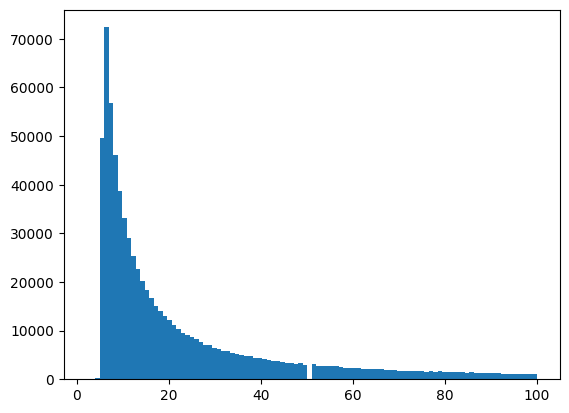

In [41]:
plt.hist(tracks.query('count <= 100')['count'], bins=100)


In [42]:
import seaborn as sns

Text(0.5, 0, 'Tracks')

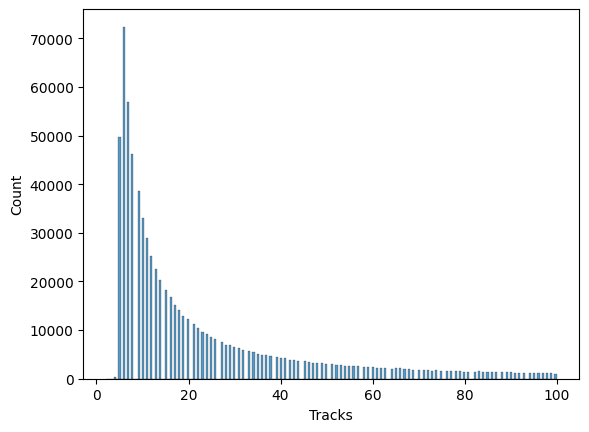

In [43]:
sns.histplot(tracks.query('count <= 100')['count'].fillna(0))
plt.xlabel('Tracks')

<b>Комментарий от ревьюера v1</b>

<div class="alert alert-block alert-success">
✔️ Отлично, приведено распределение прослушивания треков.
</div>

<div class="alert alert-warning">
    
⚠️ Стоило визуализировать распределение при помощи столбчатой диаграммы из seaborn. Например, можно было использовать `seaborn.histplot`. Такой график выглядел бы более [наглядно](https://habr.com/ru/companies/otus/articles/540526/#:~:text=sns.histplot(tips_df%5B%22tip_percentage%22%5D%2C%20binwidth%3D0.05)).
</div>
<div class="alert alert-warning">
    
⚠️ Для наглядности стоит подписать оси графика.
    

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> Спасибо. 
Я еще рекомендую (и пользуюсь на практике https://bokeh.org/ который позволяет строить интреактивные графики)
</div>

(array([ 148201.,  192358.,  172134.,  268240.,  311700.,  262459.,
         387518.,  431634.,  351026.,  505503.,  549948.,  442020.,
         624725.,  498827.,  702108.,  747713.,  592265.,  826998.,
         870964.,  683504.,  950577.,  996923.,  777570., 1074763.,
         839507., 1157846., 1207839.,  936417., 1289020., 1340665.,
        1036658., 1425276., 1475006., 1139436., 1561318., 1614665.,
        1241160., 1698673., 1311020., 1790139., 1842043., 1414538.,
        1933496., 1989027., 1527155., 2081109., 2138155., 1637404.,
        2233059., 1708755., 2324778., 2387956., 1824282., 2481403.,
        2542194., 1945960., 2644429., 2704845., 2068454., 2809762.,
        2873336., 2195813., 2983642., 2278917., 3093772., 3158010.,
        2408102., 3269353., 3334345., 2545551., 3454690., 3520903.,
        2685108., 3640694., 2771240., 3751363., 3817447., 2906555.,
        3933520., 3998960., 3035922., 4105882., 4164647., 3159655.,
        4261388., 4319254., 3273782., 4400208., 

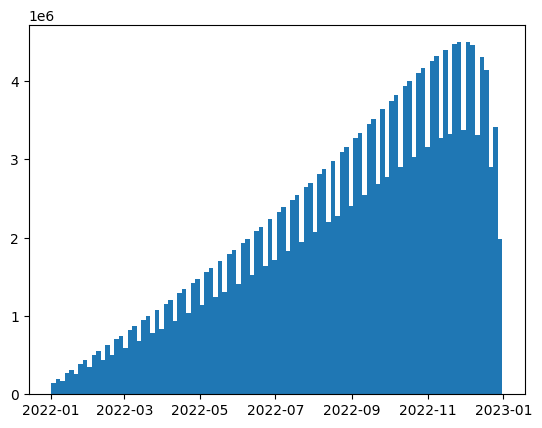

In [42]:
plt.hist(interactions['started_at'], bins=100)

<b>Комментарий от ревьюера v1</b>

<div class="alert alert-block alert-success">
✔️ Отлично, построена зависимость прослушиваний от времени.
</div>

<div class="alert alert-warning">
⚠️ Для наглядности стоит подписать оси графика. Также возможно стоило использовать другой тип графика. Например, `lineplot`.
    

Видно, что популярность сервиса растет со временем

Наиболее популярные треки

In [44]:
tracks[['track_id','count','name']].sort_values(by='count', ascending=False).head(10)
catalog_tracks = catalog_tracks.merge(tracks[['count','track_id']], left_on='id', right_on='track_id')
catalog_tracks.drop(columns=['track_id'], inplace=True)


In [45]:
catalog_tracks.sort_values('count', ascending=False).head(10)

id                     name   count
8215       53404  Smells Like Teen Spirit  111058
451664  33311009                 Believer  106918
24433     178529                     Numb  101921
478765  35505245               I Got Love   99489
774169  65851540                   Юность   86670
341295  24692821           Way Down We Go   86245
443347  32947997             Shape of You   85886
651810  51241318               In The End   85240
83809     795836        Shape Of My Heart   85042
607542  45499814                     Life   84747

/tmp/ipykernel_219026/1451962387.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  p.set_xticklabels(


[Text(0, 0, 'Smells Like Teen Spirit'),
 Text(1, 0, 'Believer'),
 Text(2, 0, 'Numb'),
 Text(3, 0, 'I Got Love'),
 Text(4, 0, 'Юность'),
 Text(5, 0, 'Way Down We Go'),
 Text(6, 0, 'Shape of You'),
 Text(7, 0, 'In The End'),
 Text(8, 0, 'Shape Of My Heart'),
 Text(9, 0, 'Life')]

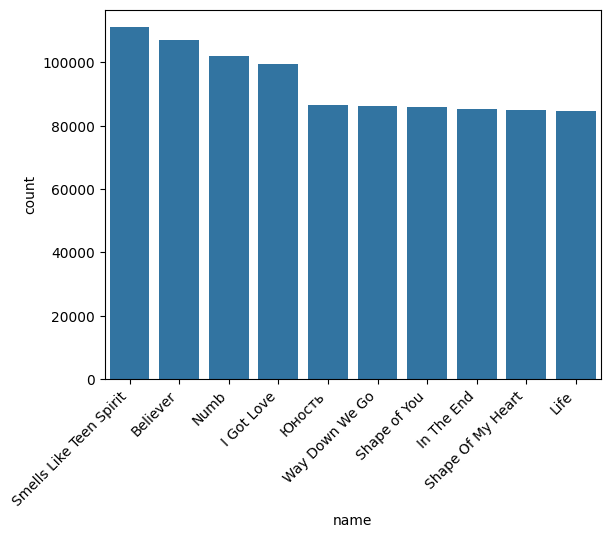

In [56]:
p = sns.barplot(catalog_tracks.sort_values('count', ascending=False).head(10),x='name', y='count')
p.set_xticklabels(
    p.get_xticklabels(), 
    rotation=45, 
    horizontalalignment='right'
)

<b>Комментарий от ревьюера v1</b>

<div class="alert alert-block alert-success">
✔️ Топ по прослушиванию выглядит логичным.
</div>

<div class="alert alert-warning">
⚠️ Можно было построить гистограмму для топ-10 прослушенных треков. Она бы выглядела более наглядно.



<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> done
</div>

In [45]:
catalog_tracks.to_parquet('data/catalog_tracks.parquet')

Наиболее популярные жанры

In [50]:

catalog_genres.sort_values('count', ascending=False).head(10)

id         name   count
11    11          pop  166109
75    75          rap  128206
102  102      allrock  118461
68    68  electronics  106478
3      3       rusrap   65958
44    44   foreignrap   59772
14    14         rock   55148
16    16        dance   51595
20    20       ruspop   46706
13    13  alternative   42894

Треки, которые никто не прослушал - нет

In [51]:
tracks_grouped.query('user_id_count == 0')

Empty DataFrame
Columns: [track_id, user_id_count, user_id_sum, user_id_max, track_seq_count, track_seq_sum, track_seq_max]
Index: []

# Преобразование данных

Преобразуем данные в формат, более пригодный для дальнейшего использования в расчётах рекомендаций.

# Сохранение данных

Сохраним данные в двух файлах в персональном S3-бакете по пути `recsys/data/`:
- `items.parquet` — все данные о музыкальных треках,
- `events.parquet` — все данные о взаимодействиях.

In [52]:
tracks.to_parquet('recsys/data/items.parquet')

In [53]:
interactions.to_parquet('recsys/data/events.parquet')

# Очистка памяти

Здесь, может понадобится очистка памяти для высвобождения ресурсов для выполнения кода ниже. 

Приведите соответствующие код, комментарии, например:
- код для удаление более ненужных переменных,
- комментарий, что следует перезапустить kernel, выполнить такие-то начальные секции и продолжить с этапа 3.

Следует перезапустить kernel, выполнять действия начиная с 3го этапа

<b>Комментарий от ревьюера v1</b>

<div class="alert alert-warning">
    
⚠️ Cтоит добавить выводы по `EDA`. Они подведут итог твоей работе.

### ВЫВОДЫ:

Больше всего треков, которые слушают менее 20 раз. Вероятно, их можно убрать из выборки для существенного сокращения размера (делать мы это конечно же не будем)

Треки из топ-10 находятся в моем сердечке :)

Топ жанров возглавляет поп, рэп, рок и электроника, остальные идут с большим отрывом в полтора-два раза по количеству треков

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> Done ^^^
</div>

# === ЭТАП 3 ===

# Загрузка данных

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import scipy
import sklearn.preprocessing
from catboost import CatBoostClassifier, Pool

In [2]:
items = pd.read_parquet('recsys/data/items.parquet')
interactions = pd.read_parquet('recsys/data/events.parquet')
#catalog = pd.read_parquet('data/catalog_names.parquet')

In [3]:
catalog_genres = pd.read_parquet('data/catalog_genres.parquet')
catalog_albums = pd.read_parquet('data/catalog_albums.parquet')
catalog_artists = pd.read_parquet('data/catalog_artists.parquet')
catalog_tracks = pd.read_parquet('data/catalog_tracks.parquet')

# Разбиение данных

Разбиваем данные на тренировочную, тестовую выборки.

In [4]:
train_test_global_time_split_date = pd.to_datetime("2022-12-16")
interactions_train = interactions.loc[interactions["started_at"] < train_test_global_time_split_date]
interactions_test = interactions.loc[interactions["started_at"] >= train_test_global_time_split_date]



<b>Комментарий от ревьюера v1</b>

<div class="alert alert-block alert-success">
    
✔️ Отлично, выборки train / test сформированы. 

Выборки train / test можно получать несколькими способами (см. картинку ниже)
</div>

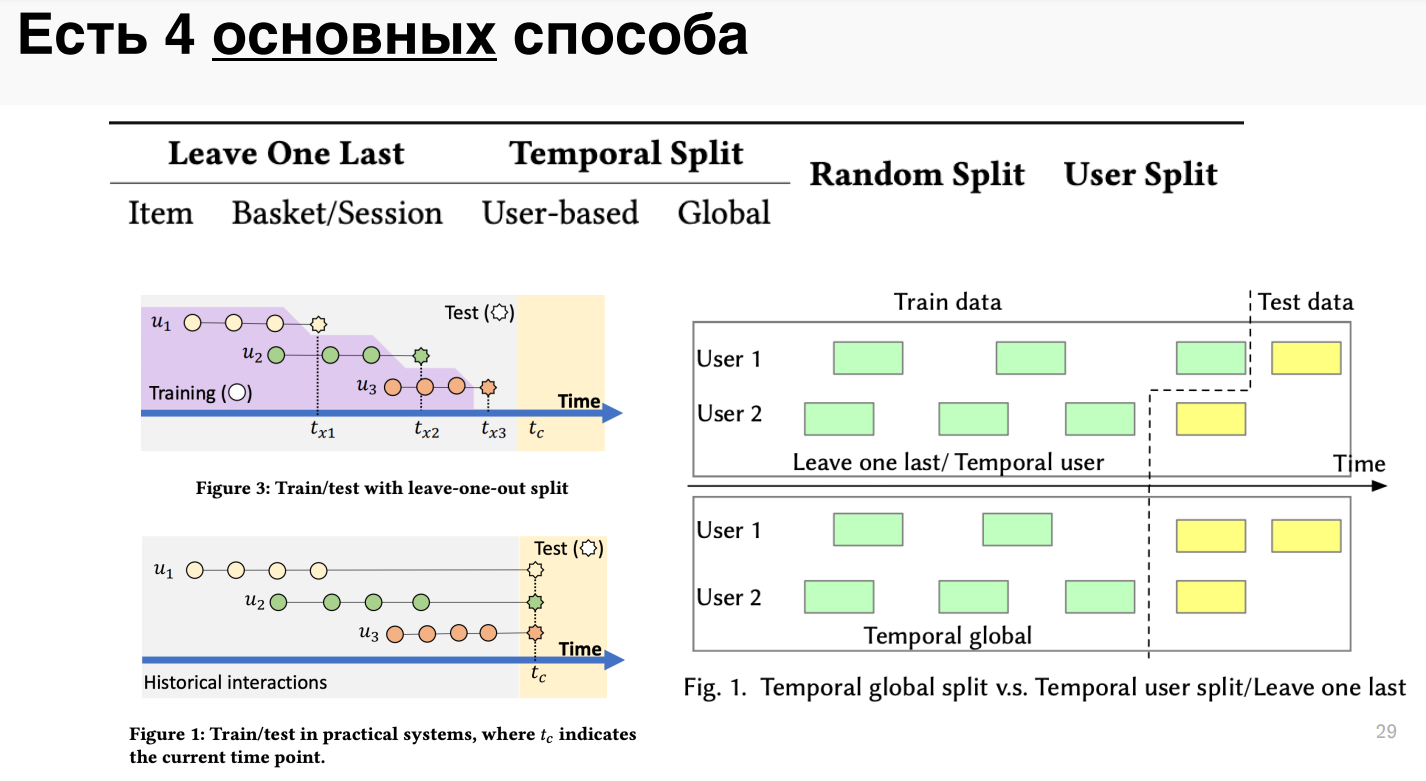

Выборки train / test можно получать несколькими способами (см. картинку ниже)
</div>

### !!!!!!!!!!!!!!!!!

In [5]:
# !!!!!!!!!!!!!!!!!
# берем 25% от всего потому что иначе все выплняется бессовестно долго. 
# Считаю что это нужно предусмотреть в курсе. Мы же учимся ml engineer а не big data
interactions_train = interactions_train.sample(frac=0.25, random_state = 42)

In [6]:
print(interactions_train.shape)
print(interactions_test.shape)

(50299870, 4)
(13514936, 4)


29477

In [8]:
# Drop items in test that are not in train
interactions_test = interactions_test.loc[~interactions_test['track_id'].isin(items_diff)]
print(interactions_test.shape)

(13438773, 4)


# Топ популярных

Рассчитаем рекомендации как топ популярных.

In [9]:
item_popularity = interactions_train.groupby('track_id')[['user_id']].count().reset_index().sort_values(by='user_id', ascending=False)[:100]
item_popularity.columns = ['track_id', 'count']
item_popularity

track_id  count
7920       53404  27471
23491     178529  25393
427095  33311009  25232
452692  35505245  23657
323047  24692821  21052
...          ...    ...
747958  68562711  11949
793610  75642961  11884
794783  75944934  11797
8394       57730  11691
746648  68348389  11651

[100 rows x 2 columns]

In [ ]:
item_popularity['rank'] = item_popularity['count'].rank(ascending=False)
item_popularity['rank'] = item_popularity['rank'].astype(int)
item_popularity = item_popularity.rename(columns= {'track_id': 'item_id'})

In [10]:
item_popularity.to_parquet('recsys/recomendations/top_popular.parquet')

<b>Комментарий от ревьюера v1</b>

<div class="alert alert-block alert-success">
    
✔️ топ-100 рекомендаций сформировано. Это сделано на train выборке. 

</div>

# Персональные

Рассчитаем персональные рекомендации.

In [11]:
interactions_train['target'] = 1 # Факт прослушивания
interactions_test['target'] = 1 # Факт прослушивания

## SVD 

Лишняя секция, Нужно было ALS!


In [12]:
# from surprise import Dataset, Reader
# from surprise import SVD

# # используем Reader из библиотеки surprise для преобразования событий (events)
# # в формат, необходимый surprise
# reader = Reader(rating_scale=(0, 1))
# surprise_train_set = Dataset.load_from_df(interactions_train[['user_id', 'track_id', 'target']], reader)
# surprise_train_set = surprise_train_set.build_full_trainset()

# # инициализируем модельinteractions_train
# svd_model = SVD(n_factors=10, random_state=42)

# # обучаем модель
# #svd_model.fit(surprise_train_set) # Несколько часов

In [13]:
# # dump svd_model to piсkle
# import pickle
# with open('recsys/data/svd_model.pkl', 'wb') as f:
#     pickle.dump(svd_model, f)


In [14]:
# surprise_test_set = list(interactions_test[['user_id', 'track_id', 'target']].itertuples(index=False))

# получаем рекомендации для тестовой выборки
# svd_predictions = svd_model.test(surprise_test_set) 

In [15]:
# from surprise import accuracy

# rmse = accuracy.rmse(svd_predictions)
# mae = accuracy.mae(svd_predictions)
                     
# print(rmse, mae) 

## ALS

In [16]:
user_encoder = sklearn.preprocessing.LabelEncoder()
user_encoder.fit(interactions["user_id"])
interactions_train["user_id_enc"] = user_encoder.transform(interactions_train["user_id"])
interactions_test["user_id_enc"] = user_encoder.transform(interactions_test["user_id"])

# перекодируем идентификаторы объектов: 
# из имеющихся в последовательность 0, 1, 2, ...
item_encoder = sklearn.preprocessing.LabelEncoder()
item_encoder.fit(items["track_id"])
items["track_id_enc"] = item_encoder.transform(items["track_id"])
interactions_train["track_id_enc"] = item_encoder.transform(interactions_train["track_id"])
interactions_test["track_id_enc"] = item_encoder.transform(interactions_test["track_id"])

In [17]:
user_item_matrix_train = scipy.sparse.csr_matrix((
    interactions_train["target"],
    (interactions_train['user_id_enc'], interactions_train['track_id_enc'])),
    dtype=np.int8) 

In [18]:
from implicit.als import AlternatingLeastSquares

als_model = AlternatingLeastSquares(factors=30, iterations=30, regularization=0.05, random_state=0)
als_model.fit(user_item_matrix_train) 

/home/andrey/work/MLE/mle-recsys-project/.venv_recsys_project/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/andrey/work/MLE/mle-recsys-project/.venv_recsys_project/lib/python3.10/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 12 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
100%|██████████| 30/30 [03:08<00:00,  6.29s/it]


In [19]:
def get_recommendations_als(user_item_matrix, model, user_id, user_encoder, item_encoder, include_seen=False, n=5):
    """
    Возвращает отранжированные рекомендации для заданного пользователя
    """
    user_id_enc = user_encoder.transform([user_id])[0]
    recommendations = model.recommend(
         user_id_enc, 
         user_item_matrix[user_id_enc], 
         filter_already_liked_items =not include_seen,
         N=n)
    recommendations = pd.DataFrame({"item_id_enc": recommendations[0], "score": recommendations[1]})
    recommendations["item_id"] = item_encoder.inverse_transform(recommendations["item_id_enc"])
    
    return recommendations

In [20]:
interactions_train

user_id  track_id  track_seq started_at  target  user_id_enc  \
273  1311288  65891271        274 2022-12-03       1      1305663   
241  1182663  35112957        242 2022-10-16       1      1177607   
134   785243  89084998        135 2022-12-14       1       781869   
14    172914     43117         15 2022-06-08       1       172180   
20    572275  20003416         21 2022-12-08       1       569812   
..       ...       ...        ...        ...     ...          ...   
621  1056259   2189518        622 2022-03-15       1      1051720   
382   278471  23344068        383 2022-04-02       1       277280   
136   682319  59373715        137 2022-11-11       1       679358   
5     955372   9548591          6 2022-08-05       1       951241   
896   689124  27759885        897 2022-06-25       1       686139   

     track_id_enc  
273        774484  
241        473510  
134        899346  
14           6832  
20         285162  
..            ...  
621        111587  
382        321471  
136        721033  
5          196517  
896        376419  

[50299870 rows x 7 columns]

In [21]:
user_id = interactions_train['user_id'].sample().iat[0]

print(f"user_id: {user_id}")

print("История (последние события, recent)")
user_history = (
    interactions_train
    .query("user_id == @user_id")
    .merge(items.set_index("track_id")[["name", "genres"]], on="track_id")
)
user_history_to_print = user_history.tail(10)
display(user_history_to_print)


user_id: 1080351
История (последние события, recent)


user_id  track_id  track_seq started_at  target  user_id_enc  \
284  1080351  54548397       1095 2022-11-19       1      1075712   
285  1080351    805089        302 2022-04-10       1      1075712   
286  1080351    178616        135 2022-02-11       1      1075712   
287  1080351  29322049        709 2022-08-04       1      1075712   
288  1080351   4391761        393 2022-05-05       1      1075712   
289  1080351    459325        207 2022-03-11       1      1075712   
290  1080351  14574063        495 2022-06-06       1      1075712   
291  1080351  23092276        617 2022-07-10       1      1075712   
292  1080351  28841594        703 2022-08-03       1      1075712   
293  1080351  21826937        604 2022-07-06       1      1075712   

     track_id_enc             name         genres  
284        682530  Burning Bridges           [68]  
285         85312             Sail  [13, 14, 102]  
286         24468        Teenagers           [13]  
287        395332            Touch      [68, 332]  
288        155742         Bullseye      [68, 432]  
289         46775        Emergency      [14, 102]  
290        222578        Get Lucky      [59, 102]  
291        318129      White Light     [68, 1197]  
292        390075    Sweet Harmony     [102, 415]  
293        311639   Blood Brothers       [41, 47]

In [22]:

print("Рекомендации")
user_recommendations_als = get_recommendations_als(user_item_matrix_train, als_model, user_id, user_encoder, item_encoder, include_seen=True)
user_recommendations_als = user_recommendations_als.merge(items.set_index("track_id")[["name", "genres"]], left_on="item_id", right_on="track_id")

display(user_recommendations_als)

Рекомендации


item_id_enc     score   item_id                         name         genres
0        59424  0.324159    628970  I Hate Everything About You           [13]
1        24399  0.258831    178495                   In the End       [41, 47]
2         5869  0.240357     37384                       Zombie      [14, 102]
3        36102  0.234098    328683             Bring Me To Life  [13, 14, 102]
4       274821  0.229506  19152669                    Centuries           [13]

In [ ]:
# !!! 45 minutes 
# чтобы не ждать - переместиться на строку считывания parquet

# получаем список всех возможных user_id (перекодированных)
user_ids_encoded = range(len(user_encoder.classes_)-1)

# получаем рекомендации для всех по+льзователей 


als_recommendations = als_model.recommend(
    user_ids_encoded, 
    user_item_matrix_train[user_ids_encoded], 
    filter_already_liked_items=False, N=30)

In [ ]:
# преобразуем полученные рекомендации в табличный формат
item_ids_enc = als_recommendations[0]
als_scores = als_recommendations[1]

als_recommendations = pd.DataFrame({
    "user_id_enc": user_ids_encoded,
    "item_id_enc": item_ids_enc.tolist(), 
    "score": als_scores.tolist()})
als_recommendations = als_recommendations.explode(["item_id_enc", "score"], ignore_index=True)

# приводим типы данных
als_recommendations["item_id_enc"] = als_recommendations["item_id_enc"].astype("int")
als_recommendations["score"] = als_recommendations["score"].astype("float")

# получаем изначальные идентификаторы
als_recommendations["user_id"] = user_encoder.inverse_transform(als_recommendations["user_id_enc"])
als_recommendations["item_id"] = item_encoder.inverse_transform(als_recommendations["item_id_enc"])
als_recommendations = als_recommendations.drop(columns=["user_id_enc", "item_id_enc"])

In [ ]:
als_recommendations = als_recommendations[["user_id", "item_id", "score"]]


In [ ]:
als_recommendations = als_recommendations.sort_values(by = "score", ascending=False)
als_recommendations.to_parquet("recsys/recomendations/personal_als.parquet") 

In [23]:
als_recommendations = pd.read_parquet("recsys/recomendations/personal_als.parquet")

<b>Комментарий от ревьюера v1</b>

<div class="alert alert-block alert-success">
✔️ Отлично, персональные рекомендации сформированы!
</div>

<div class="alert alert-warning">
    
⚠️ Стоило добавить метрики, рассчитанные для персональных рекомендаций.\
⚠️ Нам интересно получить рекомендации на для пользователей в `test` выборке. Поэтому стоило формировать рекомендации только для них.

</div>

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> Это сделано в секции ниже "Оценка качества"
</div>

# Похожие

In [ ]:

# !!!! 40 minutes
# чтобы не ждать - переместиться на строку считывания parquet

# получим энкодированные идентификаторы всех объектов, известных нам из events_train
train_item_ids_enc = interactions_train['track_id_enc'].unique()

max_similar_items = 10

# получаем списки похожих объектов, используя ранее полученную ALS-модель
# метод similar_items возвращает и сам объект, как наиболее похожий
# этот объект мы позже отфильтруем, но сейчас запросим на 1 больше


similar_items = als_model.similar_items(train_item_ids_enc, N=max_similar_items+1)

# преобразуем полученные списки в табличный формат
sim_item_item_ids_enc = similar_items[0]
sim_item_scores = similar_items[1]

similar_items = pd.DataFrame({
    "track_id_enc": train_item_ids_enc,
    "sim_item_id_enc": sim_item_item_ids_enc.tolist(), 
    "score": sim_item_scores.tolist()})
similar_items = similar_items.sort_values('score')


In [ ]:
# Надо бы сделать обратную трансформацию, но зависает спустя несколько часов работы.... Пока будем считать, что энкодед это истиные идентификаторы 
# similar_items["item_id"] = similar_items['track_id_enc'].apply(lambda x: item_encoder.inverse_transform([x])[0])
# similar_items["sim_item_id"] = similar_items['sim_item_id_enc'].apply(lambda x: item_encoder.inverse_transform(x[1:]))


<div class="alert alert-block alert-success">
✔️ Похожие треки сформированы. Ты - молодец!
</div>

<div class="alert alert-warning">
⚠️ Было бы полезно проверить "похожесть" треки на нескольких примерах, визуализировав их.

Рассчитаем похожие, они позже пригодятся для онлайн-рекомендаций.

In [ ]:
similar_items.to_parquet("recsys/recomendations/similar_items.parquet")

In [24]:
similar_items = pd.read_parquet("recsys/recomendations/similar_items.parquet")

# Построение признаков

Построим три признака, можно больше, для ранжирующей модели.

In [ ]:
# als_recommendations[["user_id", "item_id", "score"]].rename(columns={"score": "als_score"}),
#     content_recommendations_2[["user_id", "item_id", "score"]].rename(columns={"score": "cnt_score"}),
#     on=['user_id', 'item_id'],


In [ ]:
# catalog_tracks.drop(columns='count_x', inplace=True)
# catalog_tracks.rename(columns={'count_y': 'count'}, inplace=True)

In [25]:
catalog_genres

id          name  count
0       0           all      0
1       1       eastern   1186
2       2       rusrock  36649
3       3        rusrap  65958
4       4      postrock   2054
..    ...           ...    ...
161  1182        balkan    454
162  1197  experimental   1674
163  1370       europop      0
164  1484    meditation   1606
165  1542       asiapop    176

[166 rows x 3 columns]

In [26]:
# 1) средняя популярность жанров, к которым песня относится
# 14 minutes
items['genre_popularity'] = items['genres'].apply(lambda gen: sum(catalog_genres.query(f'id == {g}')['count'].values[0] for g in gen) / len(gen))

In [27]:
# 2) средняя популярность артистов, написавших трек
# 14 minutes
items['artist_popularity'] = items['artists'].apply(lambda art: sum(catalog_artists.query(f'id == {a}')['count'].values[0] for a in art) / len(art))

In [28]:
# Третий признак -  Сколько прослушано треков пользователем, рассчитывается позже
# Четвертый признак - скоры ALS-модели

In [29]:
items_in_train = set(interactions_train.track_id.unique())
items_in_test = set(interactions_test.track_id.unique())
items_diff = items_in_test.difference(items_in_train)
len(items_diff)


0

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> Согласен. Мы можем расчитать значения для треков, которых в треине не было. Но в данном случае проверил - утечки нет (см выше) 
</div>

<b>Комментарий от ревьюера v1</b>


<div class="alert alert-warning">

⚠️ На заметку: стоит аккуратно реализовывать расчет таких признаков. Так как очень легко допустить `target leak`.

# Ранжирование рекомендаций

Построим ранжирующую модель, чтобы сделать рекомендации более точными. Отранжируем рекомендации.

In [30]:
interactions_train.rename(columns = {"track_id": "item_id"}, inplace=True)
interactions_test.rename(columns = {"track_id": "item_id"}, inplace=True)
items.rename(columns = {"track_id": "item_id"}, inplace=True)


In [31]:
# Создаем отрицательные примеры - треки, котороые полтльзователь не слушал
# 7 minutes
interactions_train_zeros = interactions_train.head(0)
users_zero = random.sample(sorted(user_encoder.classes_), k = 1000)
for us in users_zero:
    tracks_zero = random.sample(sorted(item_encoder.classes_), k = 5)
    for it in tracks_zero:
        if interactions_train.loc[(interactions_train['user_id'] == us) & (interactions_train['item_id'] == it)].shape[0] == 0:
            interactions_train_zeros.loc[len(interactions_train_zeros)] = {'user_id': us, 'item_id': it, 'track_seq':0, 'started_at':'01-01-1980',  'target': 0}
        


/tmp/ipykernel_241960/661266872.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interactions_train_zeros.loc[len(interactions_train_zeros)] = {'user_id': us, 'item_id': it, 'track_seq':0, 'started_at':'01-01-1980',  'target': 0}
/tmp/ipykernel_241960/661266872.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interactions_train_zeros.loc[len(interactions_train_zeros)] = {'user_id': us, 'item_id': it, 'track_seq':0, 'started_at':'01-01-1980',  'target': 0}
/tmp/ipykernel_241960/661266872.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documen

In [32]:
# Создаем отрицательные примеры - треки, котороые полтльзователь не слушал на тестовой выборке
interactions_test_zeros = interactions_test.head(0)

users_zero = random.sample(sorted(user_encoder.classes_), k = 1000)
for us in users_zero:
    tracks_zero = random.sample(sorted(item_encoder.classes_), k = 5)
    for it in tracks_zero:
        if interactions_test.loc[(interactions_test['user_id'] == us) & (interactions_test['item_id'] == it)].shape[0] == 0:
            interactions_test_zeros.loc[len(interactions_test_zeros)] = {'user_id': us, 'item_id': it, 'track_seq':0, 'started_at':'01-01-1980', 'target': 0}
        

/tmp/ipykernel_241960/3773955109.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interactions_test_zeros.loc[len(interactions_test_zeros)] = {'user_id': us, 'item_id': it, 'track_seq':0, 'started_at':'01-01-1980', 'target': 0}
/tmp/ipykernel_241960/3773955109.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interactions_test_zeros.loc[len(interactions_test_zeros)] = {'user_id': us, 'item_id': it, 'track_seq':0, 'started_at':'01-01-1980', 'target': 0}
/tmp/ipykernel_241960/3773955109.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentat

In [ ]:
# interactions_train_zeros["user_id_enc"] = user_encoder.transform(interactions_train_zeros["user_id"])
# interactions_train_zeros["track_id_enc"] = item_encoder.transform(interactions_train_zeros["item_id"])

# interactions_test_zeros["user_id_enc"] = user_encoder.transform(interactions_test_zeros["user_id"])
# interactions_test_zeros["track_id_enc"] = item_encoder.transform(interactions_test_zeros["item_id"])



In [33]:
interactions_train = pd.concat([interactions_train, interactions_train_zeros])

In [34]:
interactions_test= pd.concat([interactions_test, interactions_test_zeros])

In [35]:
# Сколько прослушано треков пользователем
interactions_train['user_count'] = interactions_train.groupby(['user_id'])['item_id'].count().reset_index().rename(columns={'item_id': 'count'})['count']
interactions_train = interactions_train.merge(items[['item_id', 'artist_popularity', 'genre_popularity']], on='item_id', how='left')

In [36]:
# Сколько прослушано треков пользователем (test)
interactions_test['user_count'] = interactions_test.groupby(['user_id'])['item_id'].count().reset_index().rename(columns={'item_id': 'count'})['count']
interactions_test = interactions_test.merge(items[['item_id', 'artist_popularity', 'genre_popularity']], on='item_id', how='left')

In [37]:
interactions_train = interactions_train.merge(als_recommendations[["user_id", "item_id", "score"]].rename(columns={"score": "als_score"}),
    on=['user_id', 'item_id'],  how='left')

In [38]:
interactions_test = interactions_test.merge(als_recommendations[["user_id", "item_id", "score"]].rename(columns={"score": "als_score"}),
    on=['user_id', 'item_id'], how='left')

In [39]:
als_recommendations

user_id   item_id     score
12670260   424201   6705392  1.686849
16569930   554717  51241318  1.634444
14804040   495614    178529  1.624648
27005520   904089  51241318  1.560609
39323700  1316430  51241318  1.554261
...           ...       ...       ...
29697082   994196       141  0.000000
29697083   994196       140  0.000000
29697084   994196       139  0.000000
29697085   994196       138  0.000000
9611205    321750       149  0.000000

[41060970 rows x 3 columns]

In [40]:
# 7 minutes
interactions_train.to_csv("recsys/recomendations/interactions_train.csv")
interactions_test.to_csv("recsys/recomendations/interactions_test.csv")

In [64]:
interactions_train = pd.read_csv("recsys/recomendations/interactions_train.csv")
interactions_test = pd.read_csv("recsys/recomendations/interactions_test.csv") # Это отложенная выборка

In [65]:
# Формируем validation
train_to_date = pd.to_datetime("2022-11-01")
validate_from_date = pd.to_datetime("2022-11-16") # Делаем гэп между треином и валидацией
validate_to_date = train_test_global_time_split_date

interactions_train['started_at'] = interactions_train['started_at'].apply(lambda x: random.choice(['1980-01-01 12:00:00', '2022-11-20 12:00:00' ]) if x == '01-01-1980' else x ) # Заполняем корректные даты для нулевых прослушиваний
interactions_train['started_at'] = pd.to_datetime(interactions_train['started_at'])

In [66]:
interactions_train_final = interactions_train.loc[interactions_train['started_at'] < train_to_date]
interactions_valid_final = interactions_train.loc[(interactions_train['started_at'] >= validate_from_date) & (interactions_train['started_at'] < train_test_global_time_split_date)]

In [69]:
interactions_valid_final


Unnamed: 0  user_id   item_id  track_seq          started_at  \
0                  0  1311288  65891271        274 2022-12-03 00:00:00   
2                  2   785243  89084998        135 2022-12-14 00:00:00   
4                  4   572275  20003416         21 2022-12-08 00:00:00   
5                  5   810356  71769150       1145 2022-12-01 00:00:00   
11                11   784648  72872358        350 2022-11-17 00:00:00   
...              ...      ...       ...        ...                 ...   
50304861    50304861   276056  39202803          0 2022-11-20 12:00:00   
50304862    50304862   276056  14464167          0 2022-11-20 12:00:00   
50304863    50304863   276056  42134165          0 2022-11-20 12:00:00   
50304865    50304865   276227  92306552          0 2022-11-20 12:00:00   
50304867    50304867   276227  16377611          0 2022-11-20 12:00:00   

          target  user_id_enc  track_id_enc  user_count  artist_popularity  \
0              1    1305663.0      774484.0           4                6.0   
2              1     781869.0      899346.0           9              100.0   
4              1     569812.0      285162.0           2               34.0   
5              1     806854.0      815747.0           2               43.0   
11             1     781276.0      824714.0           5                6.0   
...          ...          ...           ...         ...                ...   
50304861       0          NaN           NaN          28               19.0   
50304862       0          NaN           NaN          60                7.5   
50304863       0          NaN           NaN           5               29.0   
50304865       0          NaN           NaN           7                2.0   
50304867       0          NaN           NaN           9              155.0   

          genre_popularity  als_score  
0                 166109.0        NaN  
2                  60440.5        NaN  
4                  25621.5        NaN  
5                  42894.0        NaN  
11                 97082.0   0.064885  
...                    ...        ...  
50304861            5818.0        NaN  
50304862           85507.5        NaN  
50304863           15828.0        NaN  
50304865           60440.5        NaN  
50304867          166109.0        NaN  

[8348462 rows x 12 columns]

In [70]:
interactions_train_final

Unnamed: 0  user_id   item_id  track_seq          started_at  \
1                  1  1182663  35112957        242 2022-10-16 00:00:00   
3                  3   172914     43117         15 2022-06-08 00:00:00   
6                  6  1032234  45429071        493 2022-10-13 00:00:00   
7                  7  1335200  19724261         37 2022-10-13 00:00:00   
8                  8   982704  33456001        251 2022-09-02 00:00:00   
...              ...      ...       ...        ...                 ...   
50304860    50304860   276056  45691160          0 1980-01-01 12:00:00   
50304864    50304864   276056  87647600          0 1980-01-01 12:00:00   
50304866    50304866   276227  73833150          0 1980-01-01 12:00:00   
50304868    50304868   276227   5229457          0 1980-01-01 12:00:00   
50304869    50304869   276227  57538649          0 1980-01-01 12:00:00   

          target  user_id_enc  track_id_enc  user_count  artist_popularity  \
1              1    1177607.0      473510.0           5              352.0   
3              1     172180.0        6832.0          19              237.0   
6              1    1027797.0      606385.0          16               32.0   
7              1    1329481.0      281455.0          12              107.0   
8              1     978458.0      453688.0          22              233.0   
...          ...          ...           ...         ...                ...   
50304860       0          NaN           NaN          90               33.5   
50304864       0          NaN           NaN         106              297.0   
50304866       0          NaN           NaN           1               59.0   
50304868       0          NaN           NaN          35               76.0   
50304869       0          NaN           NaN          19               82.0   

          genre_popularity  als_score  
1                  18366.0        NaN  
3                  24281.5        NaN  
6                  23792.0        NaN  
7                  19488.0        NaN  
8                  23552.0        NaN  
...                    ...        ...  
50304860           93989.0        NaN  
50304864           33606.0        NaN  
50304866           97082.0        NaN  
50304868          106478.0        NaN  
50304869          106478.0        NaN  

[37917764 rows x 12 columns]

In [71]:
features = ['user_count', 'artist_popularity', 'genre_popularity', 'als_score']
target = 'target'

candidates_for_train = interactions_train_final[features + [target]]
candidates_for_val = interactions_valid_final[features + [target]]
candidates_for_test = interactions_test[features + [target]]

In [73]:

# 15 minutes
# Create the Pool object
train_data = Pool(
    data=candidates_for_train[features], 
    label=candidates_for_train[target])

val_data = Pool(
    data=candidates_for_val[features], 
    label=candidates_for_val[target])

# инициализируем модель CatBoostClassifier
cb_model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    verbose=100,
    random_seed=0
    
)

# тренируем модель
cb_model.fit(train_data, eval_set=val_data)

0:	learn: 0.3397509	test: 0.3376250	best: 0.3376250 (0)	total: 5.65s	remaining: 28m 8s
100:	learn: 0.0007143	test: 0.0027912	best: 0.0027470 (17)	total: 3m 43s	remaining: 7m 21s
200:	learn: 0.0007143	test: 0.0027912	best: 0.0027470 (17)	total: 7m 18s	remaining: 3m 35s
299:	learn: 0.0007143	test: 0.0027912	best: 0.0027470 (17)	total: 10m 50s	remaining: 0us

bestTest = 0.002746976366
bestIteration = 17

Shrink model to first 18 iterations.


<b>Комментарий от ревьюера v1</b>

<div class="alert alert-block alert-success">
✔️ Ранжирующая модель построена.
</div>

<div class="alert alert-warning">
⚠️ Для обучения ранжирующей модели стоит использовать дополнительную отложенную выборку.
    
Вот так должно выглядеть разбиение обучающего датасета для двухстадийной модели:


<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> Добавил при обучении проверку на валидации
</div>

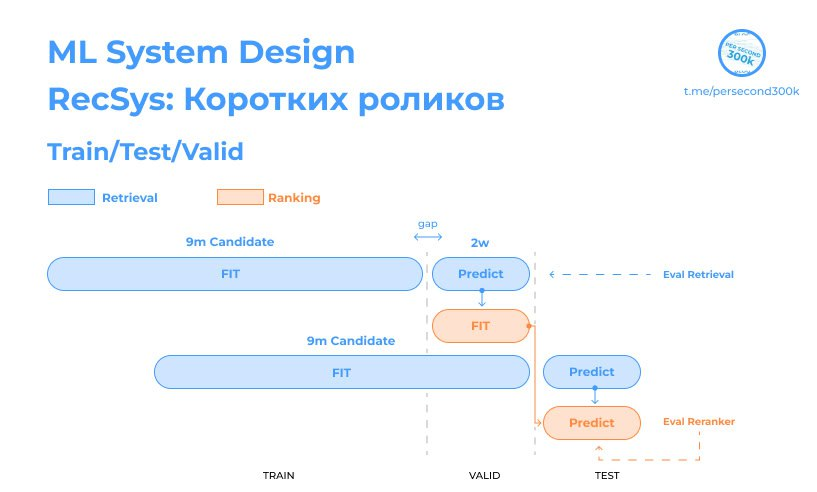

# Оценка качества

Проверим оценку качества трёх типов рекомендаций: 

- топ популярных,
- персональных, полученных при помощи ALS,
- итоговых
  
по четырем метрикам: recall, precision, coverage, novelty.

## Cold users

In [54]:
users_test = interactions_test.user_id.unique()
users_train = interactions_train.user_id.unique()
cold_users = set(users_test).difference(set(users_train))

In [57]:
interactions_test_cold_users = interactions_test.loc[interactions_test['user_id'].isin(cold_users)]

In [61]:
item_popularity

track_id  count
7920       53404  27471
23491     178529  25393
427095  33311009  25232
452692  35505245  23657
323047  24692821  21052
...          ...    ...
747958  68562711  11949
793610  75642961  11884
794783  75944934  11797
8394       57730  11691
746648  68348389  11651

[100 rows x 2 columns]

In [62]:
interactions_test_cold_users_pop = interactions_test_cold_users.loc[interactions_test_cold_users['item_id'].isin(item_popularity['track_id'])] \
    .groupby('user_id') \
    .count() \
    .reset_index()[['user_id','item_id']] \
    .rename(columns={'item_id': 'count'})

In [63]:
interactions_test_cold_users_cov = interactions_test_cold_users.loc[interactions_test_cold_users['item_id'].isin(item_popularity['track_id'])] \
    .groupby('item_id') \
    .count() \
    .reset_index()[['user_id','item_id']] \
    .rename(columns={'user_id': 'count'})

In [64]:
interactions_test_cold_users_cov.loc[interactions_test_cold_users_cov['count'] > 0].sort_values(by='count', ascending=False)

count   item_id
51   1279  33311009
55   1233  35505245
68   1232  45499814
90   1188  65851540
49   1181  32947997
..    ...       ...
50    333  33308946
5     297     57730
16    289    628970
44    194  27032843
17    163    630670

[100 rows x 2 columns]

In [65]:
print(round(len(interactions_test_cold_users_pop) / len(cold_users),2)*100, '% пользователей слушали самые популярные треки')


48.0 % пользователей слушали самые популярные треки


In [66]:
print(interactions_test_cold_users_cov.loc[interactions_test_cold_users_cov['count'] > 0].shape[0], '% популярных треков было кем-то прослушано из холодных пользователей]')


100 % популярных треков было кем-то прослушано из холодных пользователей]


<b>Комментарий от ревьюера v1</b>

<div class="alert alert-block alert-success">
✔️ Отлично, неперсональные рекомендации сформированы!
</div>


## ALS

In [80]:
def process_events_recs_for_binary_metrics(events_train, events_test, recs, top_k=None):

    """
    размечает пары <user_id, item_id> для общего множества пользователей признаками
    - gt (ground truth)
    - pr (prediction)
    top_k: расчёт ведётся только для top k-рекомендаций
    """

    events_test["gt"] = True
    common_users = set(events_test["user_id"]) & set(recs["user_id"])

    print(f"Common users: {len(common_users)}")
    
    events_for_common_users = events_test[events_test["user_id"].isin(common_users)].copy()
    recs_for_common_users = recs[recs["user_id"].isin(common_users)].copy()

    recs_for_common_users = recs_for_common_users.sort_values(["user_id", "score"], ascending=[True, False])

    # оставляет только те item_id, которые были в events_train, 
    # т. к. модель не имела никакой возможности давать рекомендации для новых айтемов
    events_for_common_users = events_for_common_users[events_for_common_users["item_id"].isin(events_train["item_id"].unique())]

    if top_k is not None:
        recs_for_common_users = recs_for_common_users.groupby("user_id").head(top_k)
    
    events_recs_common = events_for_common_users[["user_id", "item_id", "gt"]].merge(
        recs_for_common_users[["user_id", "item_id", "score"]], 
        on=["user_id", "item_id"], how="outer")    

    events_recs_common["gt"] = events_recs_common["gt"].fillna(False)
    events_recs_common["pr"] = ~events_recs_common["score"].isnull()
    
    events_recs_common["tp"] = events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fp"] = ~events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fn"] = events_recs_common["gt"] & ~events_recs_common["pr"]

    return events_recs_common

In [68]:
events_recs_for_binary_metrics = process_events_recs_for_binary_metrics(
  interactions_train,
    interactions_test, 
    als_recommendations, 
    top_k=10) 

Common users: 777085


In [82]:
def compute_cls_metrics(events_recs_for_binary_metric):
    
    groupper = events_recs_for_binary_metric.groupby("user_id")

    # precision = tp / (tp + fp)
    precision = groupper["tp"].sum()/(groupper["tp"].sum()+groupper["fp"].sum())
    precision = precision.fillna(0).mean()
    
    # recall = tp / (tp + fn)
    recall = groupper["tp"].sum()/(groupper["tp"].sum()+groupper["fn"].sum())
    recall = recall.fillna(0).mean()

    return precision, recall 

In [70]:
precision, recall  = compute_cls_metrics(events_recs_for_binary_metrics)

In [71]:
print(precision, recall)

0.006479471357702186 0.008914045157284592


In [72]:
als_recommendations.sort_values('score', ascending=False)
cov_items = als_recommendations['item_id'].unique().shape[0] / items.shape[0]

print(f"{cov_items:.3f}") 

0.002


In [83]:
# разметим каждую рекомендацию признаком read
als_recommendations = als_recommendations.merge(interactions_train, on=["user_id", "item_id"], how="left")


In [86]:
als_recommendations["listened"] = als_recommendations["target"].fillna(False).astype("bool")


In [87]:
# проставим ранги
als_recommendations = als_recommendations.sort_values(['user_id', 'score'], ascending=[True, False])
als_recommendations["rank"] = als_recommendations.groupby("user_id").cumcount() + 1

# посчитаем novelty по пользователям
novelty_5 = (1-als_recommendations.query("rank <= 5").groupby("user_id")["listened"].mean())



In [89]:
#  средний novelty
print(novelty_5.mean())

0.8766143615214156


## catboost - final recs

In [74]:
inference_data = Pool(data=interactions_test[features])

In [75]:
predictions = cb_model.predict_proba(inference_data)


In [76]:

interactions_test["cb_score"] = predictions[:, 1]

# для каждого пользователя проставляем rank, начиная с 1 — это максимальный cb_score
interactions_test = interactions_test.sort_values(["user_id", "cb_score"], ascending=[True, False])
interactions_test["rank"] = interactions_test.groupby("user_id").cumcount() + 1

max_recommendations_per_user = 10

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> снизил количество рекомендаций до 10. 100 - много
</div>

In [77]:
final_recommendations = interactions_test.query("rank <= @max_recommendations_per_user")


In [78]:
#final_recommendations.drop(columns=['Unnamed: 0.1'])
final_recommendations.drop(columns=['Unnamed: 0'])
final_recommendations

Unnamed: 0  user_id   item_id  track_seq           started_at  \
0                  0        3  78194999         33  2022-12-20 00:00:00   
11                11        4  98766295        256  2022-12-29 00:00:00   
4                  4        4  84487963        249  2022-12-23 00:00:00   
6                  6        4  86836928        251  2022-12-26 00:00:00   
10                10        4  94227416        255  2022-12-28 00:00:00   
...              ...      ...       ...        ...                  ...   
13438714    13438714  1374582  82781122        234  2022-12-20 00:00:00   
13438726    13438726  1374582  84543360        246  2022-12-22 00:00:00   
13438735    13438735  1374582  86169470        255  2022-12-24 00:00:00   
13438736    13438736  1374582  86263362        256  2022-12-24 00:00:00   
13438741    13438741  1374582  87080102        261  2022-12-25 00:00:00   

          target  user_id_enc  track_id_enc  user_count  artist_popularity  \
0              1          3.0      853840.0           3               56.0   
11             1          4.0      929193.0           8              249.0   
4              1          4.0      882577.0           7              172.0   
6              1          4.0      891531.0          34              163.0   
10             1          4.0      917738.0           3              168.0   
...          ...          ...           ...         ...                ...   
13438714       1    1368699.0      876002.0           5               72.0   
13438726       1    1368699.0      882808.0           8              115.0   
13438735       1    1368699.0      889131.0           3               81.0   
13438736       1    1368699.0      889493.0           8               83.0   
13438741       1    1368699.0      892262.0           1              159.0   

          genre_popularity  als_score  cb_score  rank  
0                  97082.0        NaN  0.999743     1  
11                106407.5        NaN  0.999782     1  
4                  97082.0        NaN  0.999776     2  
6                  97082.0        NaN  0.999772     3  
10                 23552.0        NaN  0.999718     4  
...                    ...        ...       ...   ...  
13438714          106407.5        NaN  0.999782     6  
13438726          106407.5        NaN  0.999782     7  
13438735          106407.5        NaN  0.999782     8  
13438736          106407.5        NaN  0.999782     9  
13438741          106407.5        NaN  0.999782    10  

[4658582 rows x 14 columns]

In [93]:

cb_events_recs_for_binary_metrics_5 = process_events_recs_for_binary_metrics(
    interactions_train_final,
    interactions_test,
    final_recommendations.rename(columns={"cb_score": "score"}), 
    top_k=5)

cb_precision_5, cb_recall_5= compute_cls_metrics(cb_events_recs_for_binary_metrics_5)

print(f"precision: {cb_precision_5:.3f}, recall: {cb_recall_5:.3f}")

Common users: 777081
precision: 0.990, recall: 0.657


In [94]:
final_recommendations.to_parquet("recsys/recomendations/recommendations.parquet")

# === Выводы, метрики ===

Основные выводы при работе над расчётом рекомендаций, рассчитанные метрики.

1) Рекомендации по умолчанию - топ 100 наиболее популярных треков оказались достаточно показательными:

Среди холодных пользователей 48.0% слушали хотя бы 1 трек из самых популярных.

При этом, каждый из топ-100 треков был прослушан пользователями  минимум 163 раза.



2) Исходные рекомендации алгоритмом ALS получились невысокие

precision: 0.0064 recall: 0.0089

а coverage составил 0.002, 

при этом, novelty@5 = 0.876 что является хорошим показателем.
 


3) Финальные рекомендации строились алгоритмом catboost и состояли из признаков:

['user_count', 'artist_popularity', 'genre_popularity', 'als_score'] - количество пользователей, слушавших трек. популярность артиста, жанра и скора als-модели

метрики получились достаточно неплохими:

precision: 0.990, recall: 0.657


<b>Комментарий от ревьюера v1</b>

<div class="alert alert-block alert-success">
✔️ Метрики для ALS выглядят правдоподобно, отличная работа!
</div>

<div class="alert alert-warning">
⚠️ Рекомендовать пользователю 100 треков кажется избыточным, не правда ли?
</div>


<div class="alert alert-block alert-danger">
❌ Такие метрики получились скорее всего из-за target leak при разбиении выборки для обучения ранжирующей модели. Просьба скорректировать разбиение на выборки для обучения модели ранжирования.
</div>

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> Проверил - data leak нет, но добавил проверку на валидации, а также изменил top_k = 5 при расчете precision и recall.
Теперь метрики @5 вместо @10 что логичнее смотреть - угадать среди топ-10 гораздо проще
</div>

<b>Комментарий от ревьюера v1</b>


    
# Общий вывод
<div class="alert alert-block alert-success">

Спасибо за работу, у тебя получился отличный проект!\
Удалось протестировать различные алгоритмы для формирования рекомендаций. Пока есть критические замечания, просьба их исправить.
Также есть небольшие советы, просьба ознакомиться с ними.
Если есть вопросы или желание улучшить твой проект - оставь вопросы комментарии после этой ячейки. Постараюсь тебе помочь с ответами и улучшением твоего проекта! 
</div>